In [161]:
from utils.database_connection import DatabaseConnection
import utils.results_repository as rep
import pandas as pd
import numpy as np
from utils.column_name_utils import *
import utils.query_utils as query
import matplotlib.pyplot as plot

In [162]:
db = DatabaseConnection()

Connected to MySQL Server version  8.0.31-23


In [163]:
measurements_used = 25

In [164]:
experiment_name = "same-cpp-multi-core-micro-benchmark-different-compiler"
experiment_number = 1

used_dut_name = [
    'workstationone'
]

used_dut_env = 'prod'

used_test_case_names = [
    'fannkuch-redux.exe',
    'mandelbrot.exe'
]

used_compilers = [
    'clang'
]

used_thread = [
    'multi-threaded'
]

used_test_case_name = 'idle-case.exe'

ipg = "ipg"
lhm = "lhm"

used_mi_names = [
    ipg, lhm
]

ipg_sample_rate = 333
lhm_sample_rate = 100

used_min_temp = 0
used_max_temp = 200
used_burn_in = 1
used_allocated_cores = [
    []
]

### DUTs

In [165]:
used_dut_name_str = "','".join(used_dut_name)

In [166]:
dut = rep.get_devices_under_test(db)

dut

,Id,Name,Os,Env
0,1,workstationone,win32nt,prod


In [167]:
used_dut = dut.query(f"{ENV} == '{used_dut_env}' and {NAME} in ('{used_dut_name_str}')")

### Test Cases

In [168]:
tc = rep.get_test_cases(db)

tc

,Id,Name,Compiler,Language,Optimizations,TestCaseSize,Parameter,Threads
0,1,fannkuch-redux.exe,clang,c++,-openmp,microbenchmarks,12,multi-threaded
1,2,mandelbrot.exe,clang,c++,-openmp,microbenchmarks,16000,multi-threaded
2,3,idle-case.exe,clang,c++,-openmp,microbenchmarks,,multi-threaded
3,4,fannkuch-redux.exe,intel-one-api,c++,-openmp,microbenchmarks,12,multi-threaded
4,5,mandelbrot.exe,intel-one-api,c++,-openmp,microbenchmarks,16000,multi-threaded
5,6,idle-case.exe,intel-one-api,c++,-openmp,microbenchmarks,,multi-threaded
6,7,fannkuch-redux.exe,min-gw,c++,-openmp,microbenchmarks,12,multi-threaded
7,8,mandelbrot.exe,min-gw,c++,-openmp,microbenchmarks,16000,multi-threaded
8,9,idle-case.exe,min-gw,c++,-openmp,microbenchmarks,,multi-threaded
9,10,fannkuch-redux.exe,msvc,c++,-openmp,microbenchmarks,12,multi-threaded


In [169]:
used_test_case_name_str = "','".join(used_test_case_names)
used_compiler_str = "','".join(used_compilers)
used_thread_str = "','".join(used_thread)

used_tc = tc.query(f"{COMPILER} in ('{used_compiler_str}') and {NAME} in ('{used_test_case_name_str}') and {THREADS} in ('{used_thread_str}')")

In [170]:
used_idle_case = tc.query(f"{COMPILER} in ('{used_compiler_str}') and {NAME} == '{used_test_case_name}' and {THREADS} in ('{used_thread_str}')")

### Measuring Instruments

In [171]:
mi = rep.get_measuring_instruments(db)

mi

,Id,Name,SampleRate
0,1,lhm,100
1,2,ipg,333


In [172]:
used_mi = mi.query(f"({NAME} == '{ipg}' and {SAMPLE_RATE} == {ipg_sample_rate}) or ({NAME} == '{lhm}' and {SAMPLE_RATE} == {lhm_sample_rate})")

### Configurations

In [173]:
used_allocated_cores_str = "','".join([str(x) for x in used_allocated_cores])

In [174]:
config = rep.get_configurations(db)

config

,Id,MinTemp,MaxTemp,Burnin,AllocatedCores
0,1,0,200,1,[]


In [175]:
used_configs = config.query(f"{MIN_TEMP} == {used_min_temp} and " +
                            f"{MAX_TEMP} == {used_max_temp} and " +
                            f"{BURN_IN} == {used_burn_in} and " +
                            f"{ALLOCATED_CORES} in ('{used_allocated_cores_str}')")

### Experiment Names

In [176]:
exp = rep.get_distinct_experiments(db)

exp

,Experiment,Name
0,1,same-cpp-multi-core-micro-benchmark-different-...


## Used Things

In [177]:
used_dut

,Id,Name,Os,Env
0,1,workstationone,win32nt,prod


In [178]:
used_tc

,Id,Name,Compiler,Language,Optimizations,TestCaseSize,Parameter,Threads
0,1,fannkuch-redux.exe,clang,c++,-openmp,microbenchmarks,12,multi-threaded
1,2,mandelbrot.exe,clang,c++,-openmp,microbenchmarks,16000,multi-threaded


In [179]:
used_mi

,Id,Name,SampleRate
0,1,lhm,100
1,2,ipg,333


In [180]:
used_idle_case

,Id,Name,Compiler,Language,Optimizations,TestCaseSize,Parameter,Threads
2,3,idle-case.exe,clang,c++,-openmp,microbenchmarks,,multi-threaded


In [181]:
used_configs

,Id,MinTemp,MaxTemp,Burnin,AllocatedCores
0,1,0,200,1,[]


In [182]:
cpu_energy_results = {}
dram_energy_results = {}
gpu_energy_results = {}
duration_results = {}

for dut_index, dut_row in used_dut.iterrows():
    dut_id = dut_row[ID]
    for mi_index, mi_row in used_mi.iterrows():
        mi_id = mi_row[ID]
        mi_name = mi_row[NAME]
        for config_index, config_row in used_configs.iterrows():
            config_id = config_row[ID]
            for tc_index, tc_row in used_tc.iterrows():
                tc_id = tc_row[ID]
                tc_name = tc_row[NAME]
                tc_compiler = tc_row[COMPILER]
                tc_language = tc_row[LANGUAGE]
                tc_optimizations = tc_row[OPTIMIZATIONS]
                tc_test_case_size = tc_row[TEST_CASE_SIZE]
                tc_threads = tc_row[THREADS]
                
                tc_idle_case = query.get_idle_case(used_idle_case, tc_compiler, tc_language, tc_optimizations, tc_test_case_size, tc_threads)
                tc_idle_case_id =int(tc_idle_case[ID].iloc[0])
                
                tc_collection = rep.get_collections(db, dut_id, mi_id, config_id, tc_id, experiment_name, experiment_number)
                tc_idle_case_collection = rep.get_collections(db, dut_id, mi_id, config_id, tc_idle_case_id, experiment_name, experiment_number)
                
                tc_collection_id = int(tc_collection[ID].iloc[0])
                tc_idle_case_collection_id = int(tc_idle_case_collection[ID].iloc[0])
                
                tc_measurements = rep.get_measurements(db, tc_collection_id)
                tc_idle_case_measurements = rep.get_measurements(db, tc_idle_case_collection_id)
                
                key = f"{tc_name}.{mi_name}"
                
                dram_energy_results[key] = list(tc_measurements["DramEnergyInJoules"])
                cpu_energy_results[key] = list(tc_measurements["CpuEnergyInJoules"])
                gpu_energy_results[key] = list(tc_measurements["GpuEnergyInJoules"])
                duration_results[key] = list(tc_measurements["Duration"])

In [183]:
for key, value in dram_energy_results.items():
    dram_energy_results[key] = value[:measurements_used]
    
for key, value in cpu_energy_results.items():
    cpu_energy_results[key] = value[:measurements_used]

for key, value in gpu_energy_results.items():
    gpu_energy_results[key] = value[:measurements_used]

for key, value in duration_results.items():
    duration_results[key] = value[:measurements_used]

In [184]:
dram_df = pd.DataFrame(dram_energy_results)
cpu_df = pd.DataFrame(cpu_energy_results)
gpu_df = pd.DataFrame(gpu_energy_results)
duration_df = pd.DataFrame(duration_results)

DRAM


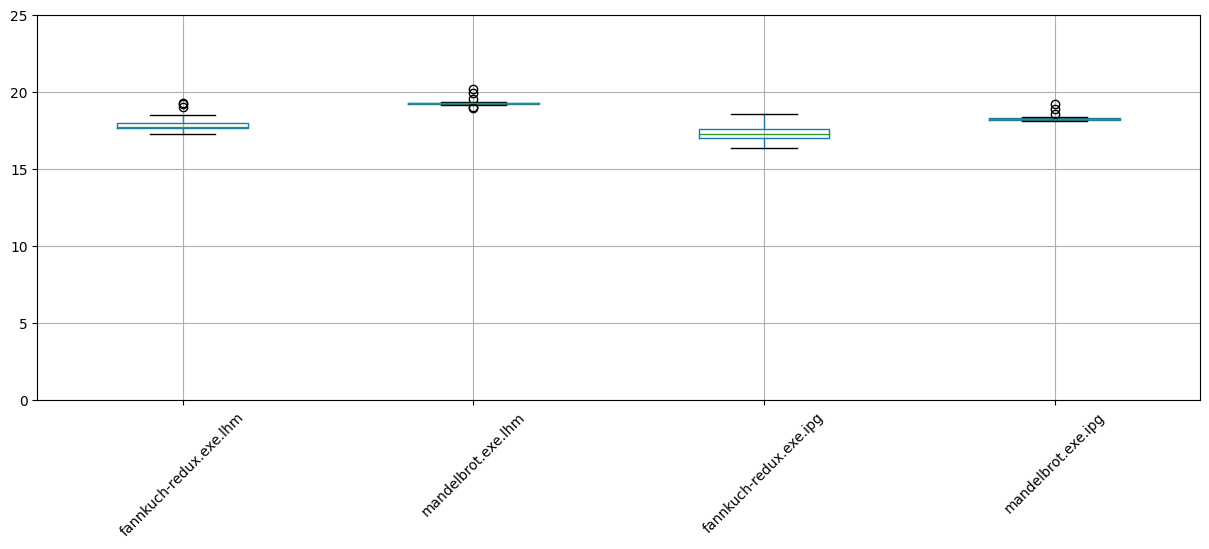

CPU


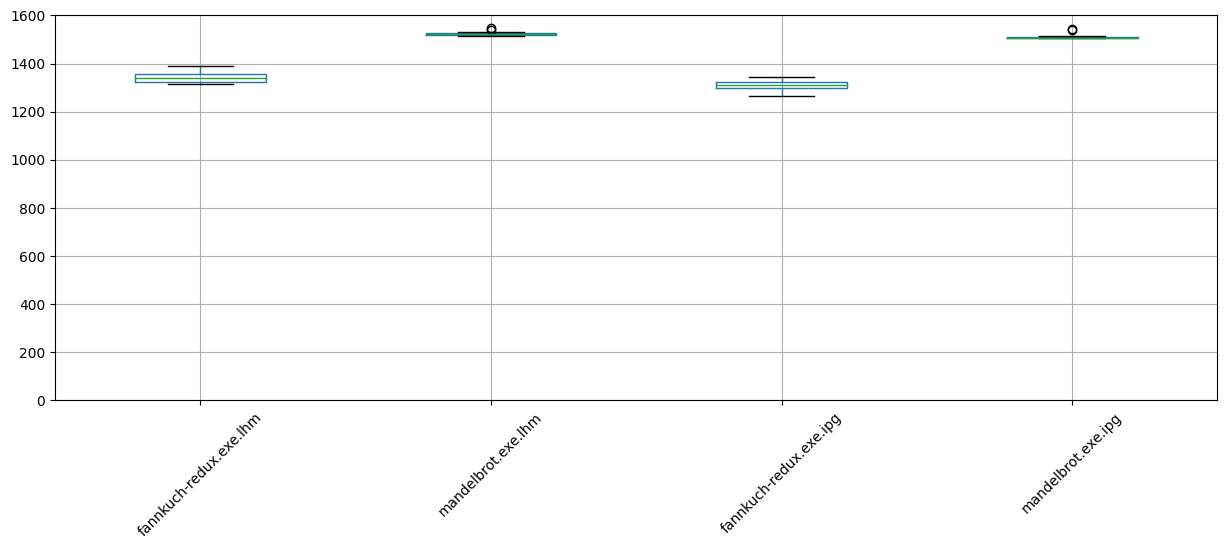

GPU


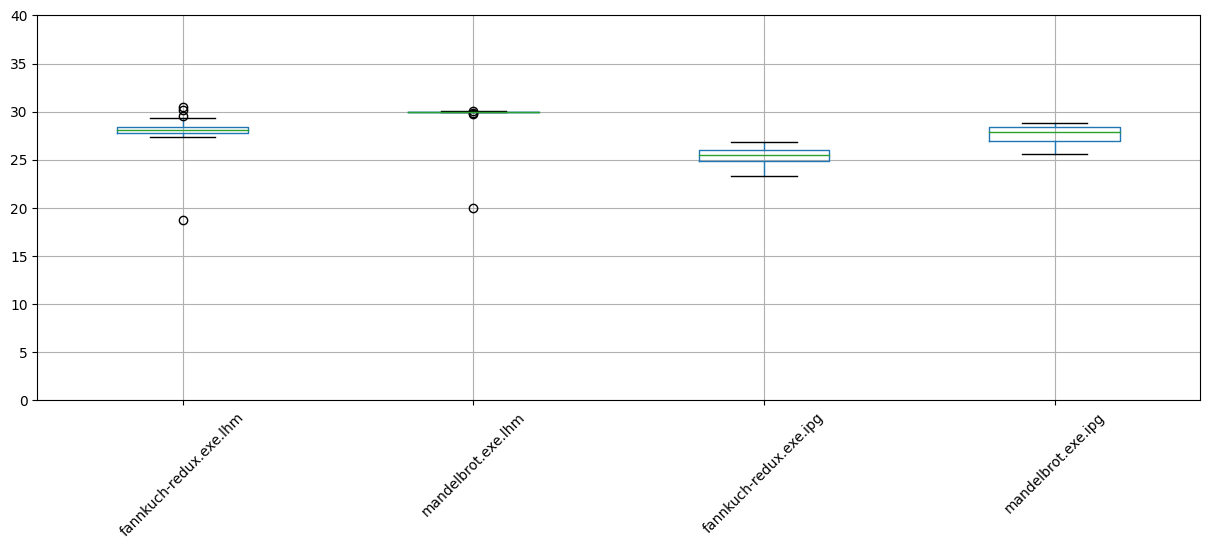

In [187]:
print("DRAM")
dram_boxplot = dram_df.boxplot(figsize=(15,5), rot=45)
dram_boxplot.plot()
plot.ylim(0,25)
plot.show()

print("CPU")
cpu_boxplot = cpu_df.boxplot(figsize=(15,5), rot=45)
cpu_boxplot.plot()
cpu_boxplot
plot.ylim(0,1600)
plot.show()

print("GPU")
gpu_boxplot = gpu_df.boxplot(figsize=(15,5), rot=45)
gpu_boxplot.plot()
plot.ylim(0,40)
plot.show()